In [10]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, haswell)
Threads: 1 default, 0 interactive, 1 GC (on 32 virtual cores)
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [11]:
# set the output format of gr backend to png while the default is svg, which disappears in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

@time using StatsPlots; 
@time gr(fmt = :png)

  2.011342 seconds (1.31 M allocations: 81.792 MiB, 0.95% gc time, 10.53% compilation time: 89% of which was recompilation)
  0.000050 seconds (5 allocations: 576 bytes)
  1.449801 seconds (771.83 k allocations: 39.546 MiB, 8.81% gc time, 1.66% compilation time: 100% of which was recompilation)
  0.000038 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

# 1 Incorrect probability density from different forms of the same distribution: Beta(1,1) vs Dirichlet([1,1])

- SOLVED.

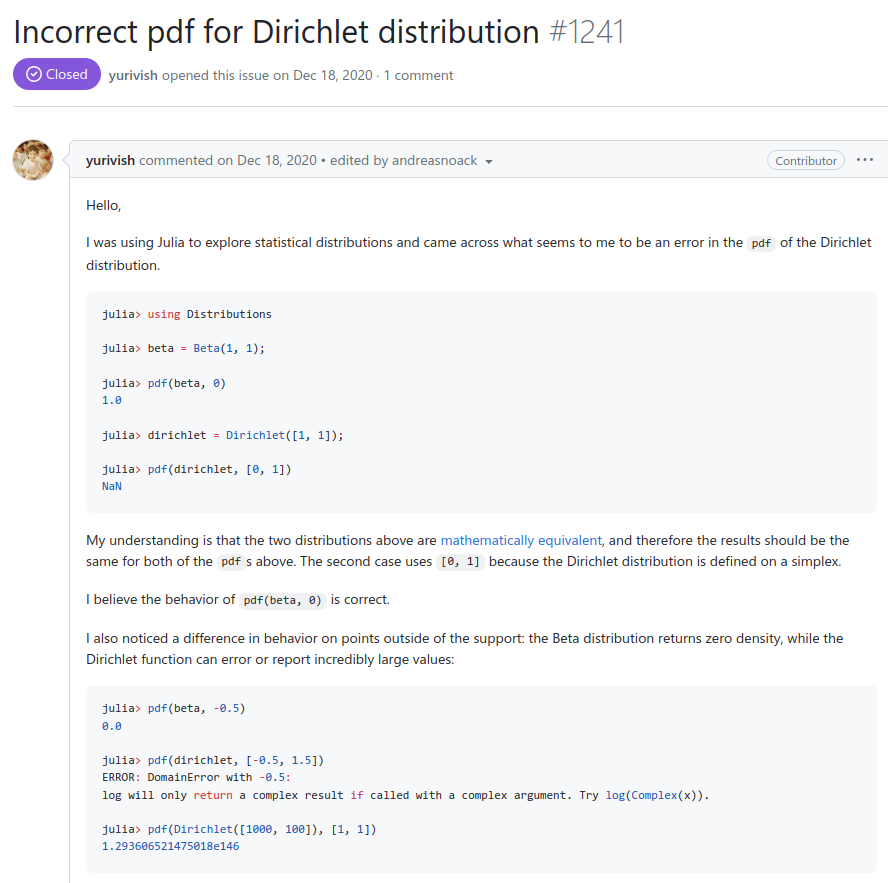

- https://github.com/JuliaStats/Distributions.jl/issues/1241
- https://stats.stackexchange.com/questions/78618/what-is-the-dirichlet-equivalent-of-a-beta-1-1-distribution


In [12]:
using Distributions;
beta = Beta(1, 1);
@show pdf(beta, 0);
dirichlet = Dirichlet([1, 1]);
@show pdf(dirichlet, [0, 1]);

pdf(beta, 0) = 1.0
pdf(dirichlet, [0, 1]) = 1.0


In [13]:
# test for impossible values
@show @time pdf(beta, -0.5);
@show @time pdf(dirichlet, [-0.5, 1.5]);
@show @time pdf(Dirichlet([1000, 100]), [1, 1]);

  0.004283 seconds (1.25 k allocations: 88.367 KiB, 98.91% compilation time)
#= In[13]:2 =# @time(pdf(beta, -0.5)) = 0.0
  0.088154 seconds (138.02 k allocations: 9.336 MiB, 99.95% compilation time)
#= In[13]:3 =# @time(pdf(dirichlet, [-0.5, 1.5])) = 0.0
  0.000004 seconds (2 allocations: 160 bytes)
#= In[13]:4 =# @time(pdf(Dirichlet([1000, 100]), [1, 1])) = 0.0


# 2 Sampling is biased when the destination array is equal to the sampled array.

- Partially SOVLED.
- Shared-memory in-replace sampling still produces incorrect result (fisher_yates_sample()) or throw an error.
- The author didn't add checks to unexported methods such as fisher_yates_sample!, as they are internal and don't check array indices either. We could add a warning to the manual.
- Fisher-Yates shuffle is an algorithm for shuffling a finite sequence. The algorithm takes a list of all the elements of the sequence, and continually determines the next element in the shuffled sequence by randomly drawing an element from the list until no elements remain.[1] The algorithm produces an unbiased permutation: every permutation is equally likely. The modern version of the algorithm takes time proportional to the number of items being shuffled and shuffles them in place.

- https://github.com/JuliaStats/StatsBase.jl/issues/642.

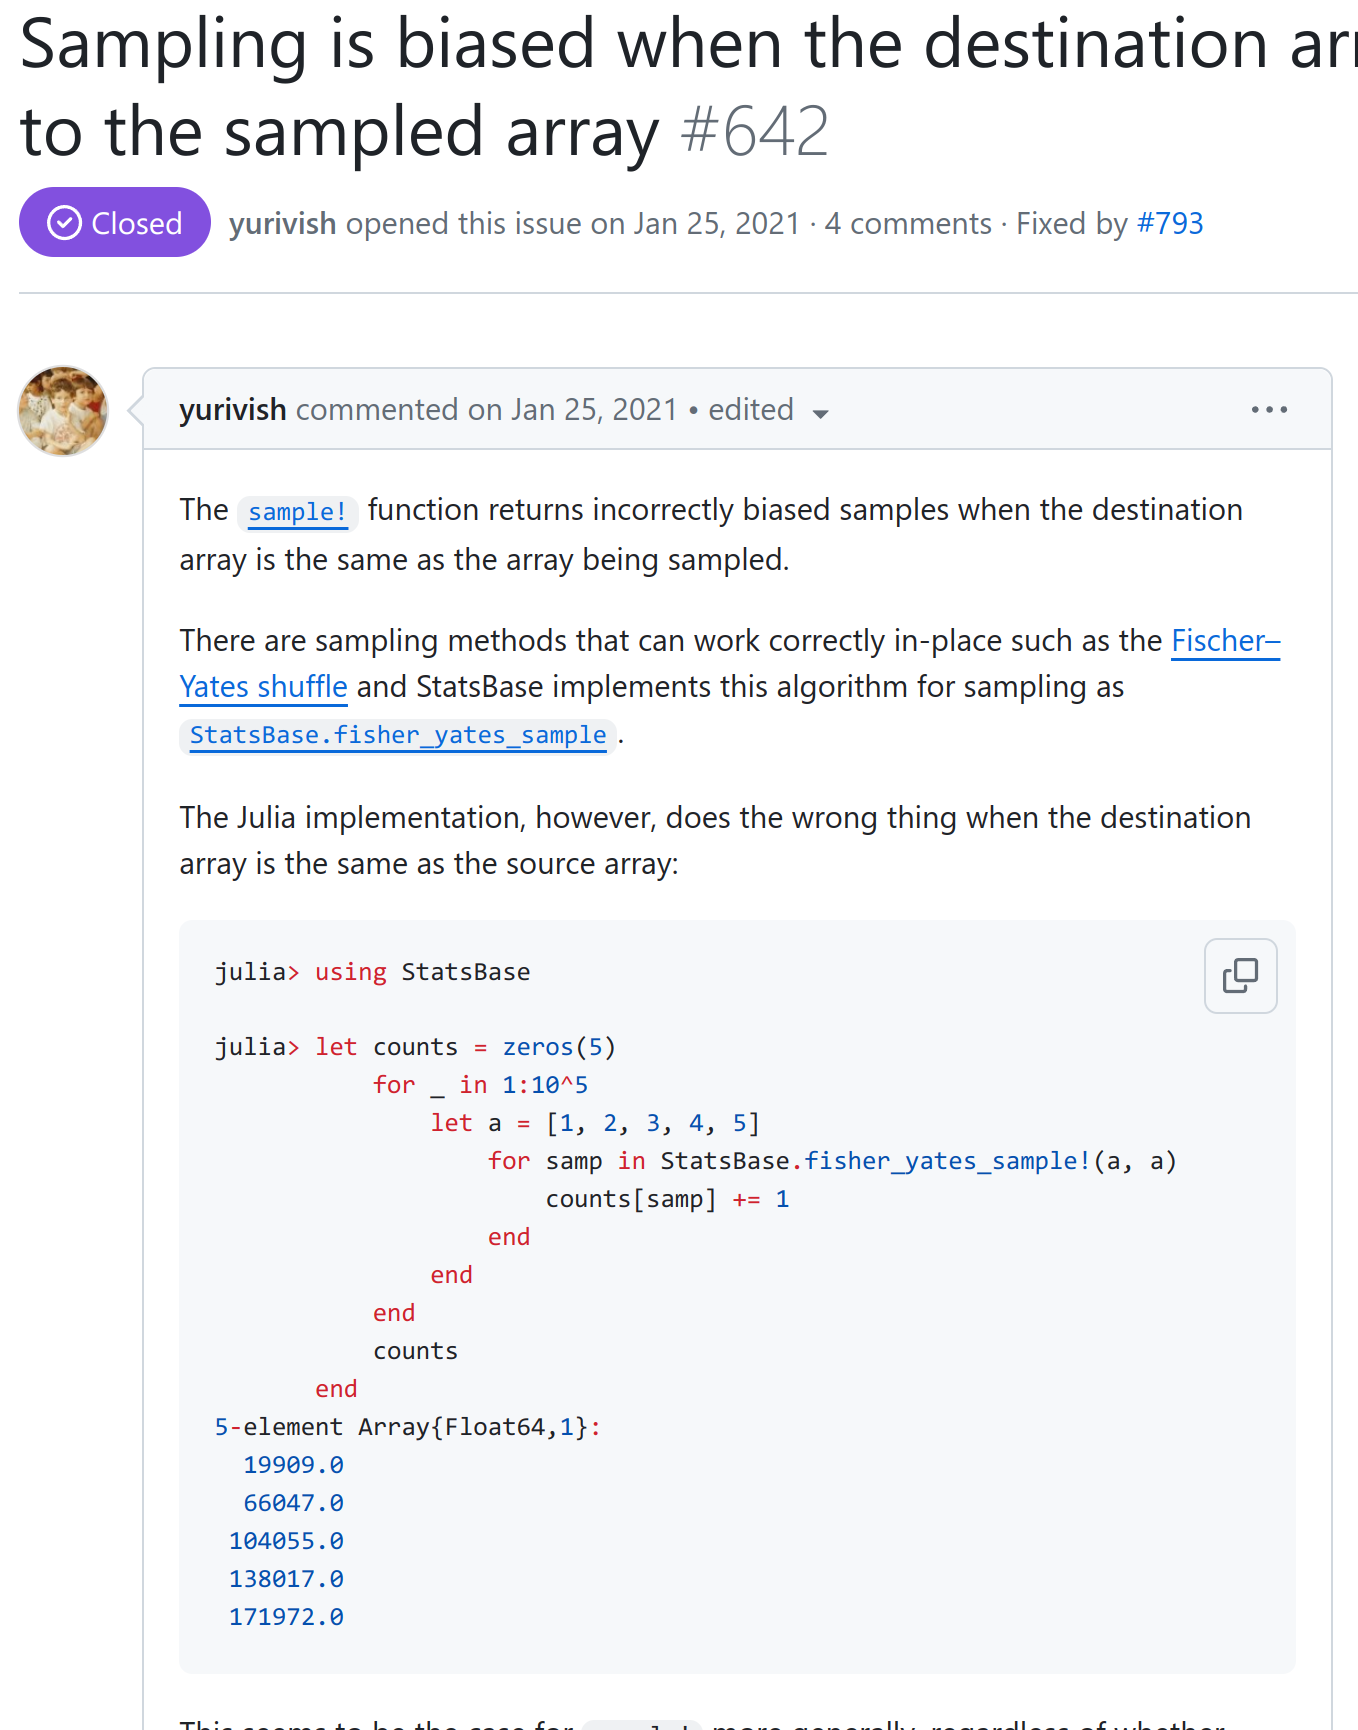


In [23]:
using StatsBase;
using Pkg;
Pkg.status("StatsBase")

Status `~/.julia/environments/v1.10/Project.toml`
⌅ [2913bbd2] StatsBase v0.33.21
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [21]:
let counts = zeros(5)
   for _ in 1:10^5
       let a = [1, 2, 3, 4, 5]
           for samp in StatsBase.fisher_yates_sample!(a, a)
               counts[samp] += 1
           end
       end
   end
   counts
end

5-element Vector{Float64}:
  20165.0
  65422.0
 104112.0
 138967.0
 171334.0

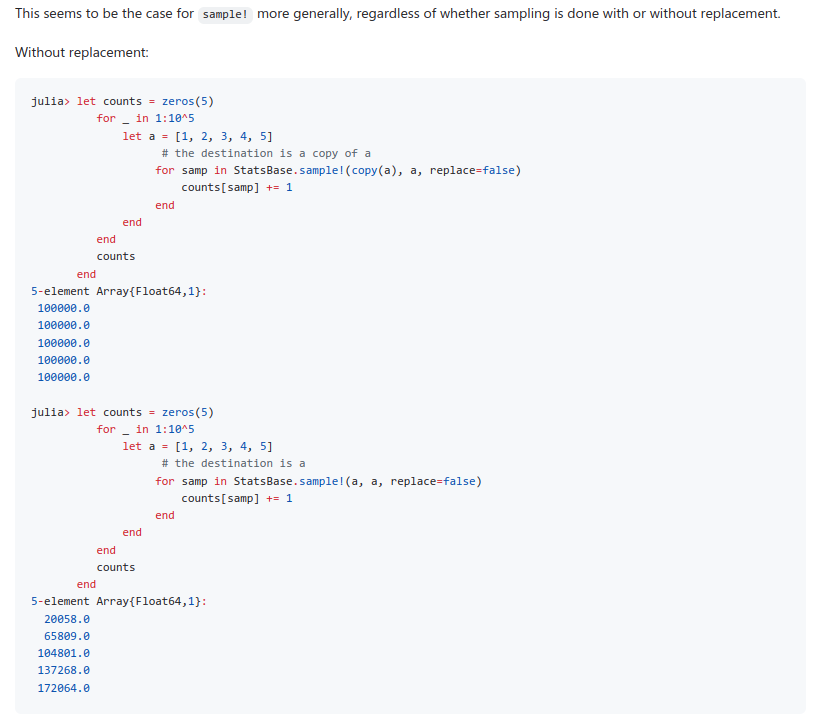

In [15]:
let counts = zeros(5)
  for _ in 1:10^5
      let a = [1, 2, 3, 4, 5]
            # the destination is a copy of a
           for samp in StatsBase.sample!(copy(a), a, replace=false)
               counts[samp] += 1
           end
      end
  end
  counts
end

5-element Vector{Float64}:
 100000.0
 100000.0
 100000.0
 100000.0
 100000.0

In [24]:
# Now it threw an error.
let counts = zeros(5)
  for _ in 1:10^5
      let a = [1, 2, 3, 4, 5]
            # the destination is a
           for samp in StatsBase.sample!(a, a, replace=false)
               counts[samp] += 1
           end
      end
  end
  counts
end

LoadError: ArgumentError: output array a must not share memory with input array x

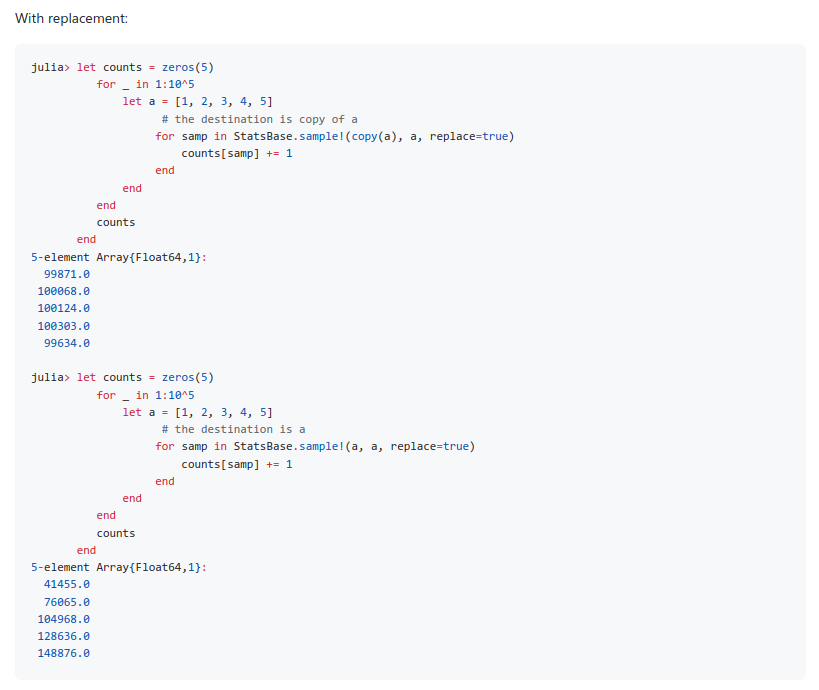

In [17]:
let counts = zeros(5)
  for _ in 1:10^5
      let a = [1, 2, 3, 4, 5]
            # the destination is copy of a
           for samp in StatsBase.sample!(copy(a), a, replace=true)
               counts[samp] += 1
           end
      end
  end
  counts
end

5-element Vector{Float64}:
 100410.0
  99820.0
  99692.0
 100046.0
 100032.0

In [18]:
# throws an error for share-memory sample!()
let counts = zeros(5)
  for _ in 1:10^5
      let a = [1, 2, 3, 4, 5]
            # the destination is a
           for samp in StatsBase.sample!(a, a, replace=true)
               counts[samp] += 1
           end
      end
  end
  counts
end

LoadError: ArgumentError: output array a must not share memory with input array x

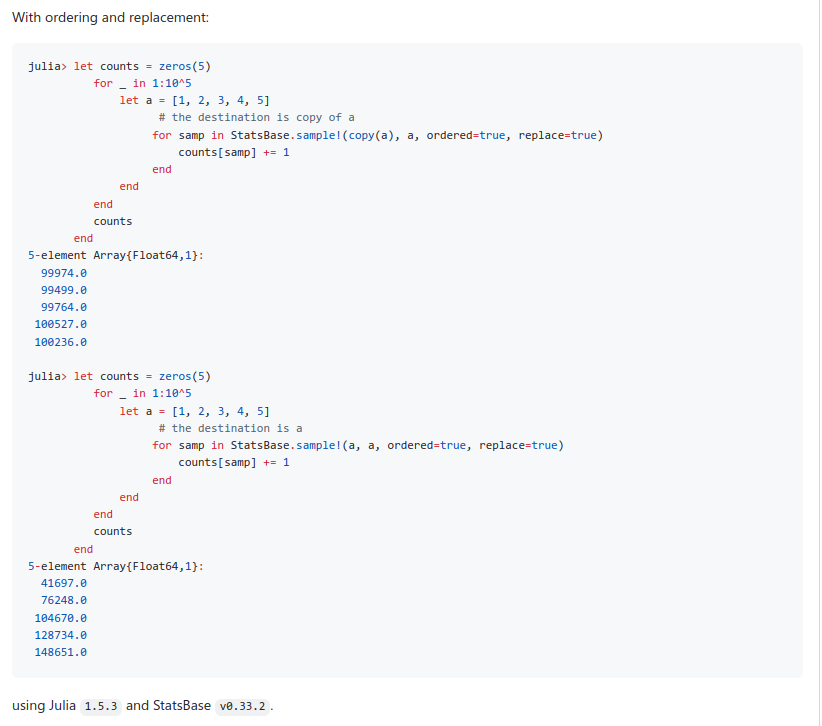

In [19]:
let counts = zeros(5)
  for _ in 1:10^5
      let a = [1, 2, 3, 4, 5]
            # the destination is copy of a
           for samp in StatsBase.sample!(copy(a), a, ordered=true, replace=true)
               counts[samp] += 1
           end
      end
  end
  counts
end

5-element Vector{Float64}:
 100393.0
 100376.0
  99589.0
  99688.0
  99954.0

In [20]:
let counts = zeros(5)
  for _ in 1:10^5
      let a = [1, 2, 3, 4, 5]
            # the destination is a
           for samp in StatsBase.sample!(a, a, ordered=true, replace=true)
               counts[samp] += 1
           end
      end
  end
  counts
end

LoadError: ArgumentError: output array a must not share memory with input array x

# 3 The product function can produce incorrect results for 8-bit, 16-bit, and 32-bit integers
- SOLVED.

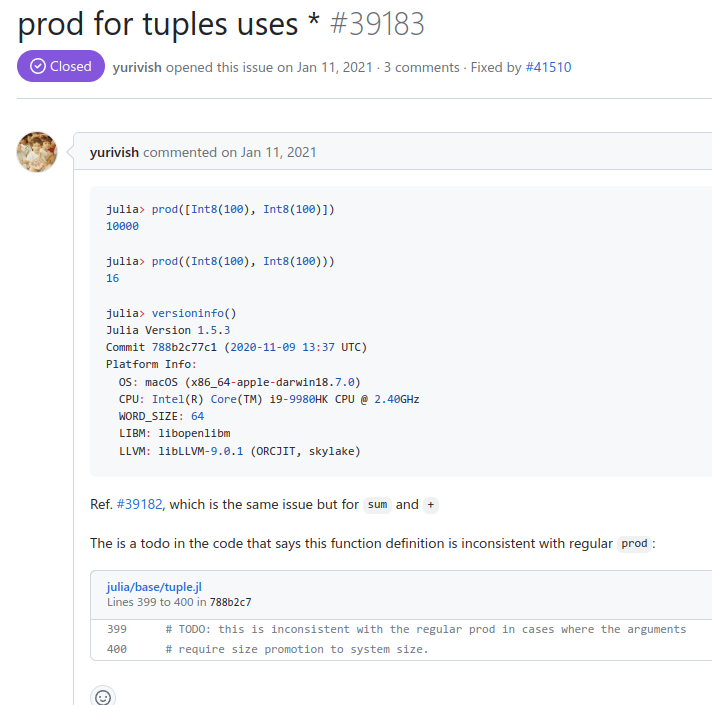

- https://github.com/JuliaLang/julia/issues/39183


In [2]:
@time prod([Int8(100), Int8(100)])

  0.000003 seconds (1 allocation: 64 bytes)


10000

In [1]:
@time prod((Int8(100), Int8(100)))

  0.000000 seconds


10000

# 4 Incorrect Histogram fit for arrays of equal Float64 values

- SOLVED.
- https://github.com/JuliaStats/StatsBase.jl/issues/616

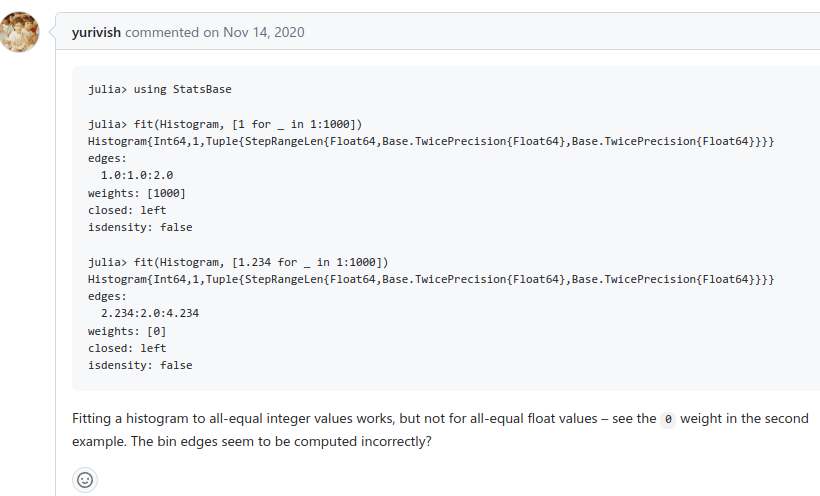

In [5]:
using StatsBase

In [6]:
fit(Histogram, [1 for _ in 1:1000])

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  1.0:1.0:2.0
weights: [1000]
closed: left
isdensity: false

In [7]:
fit(Histogram, [1.234 for _ in 1:1000])

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  1.234:1.0:2.234
weights: [1000]
closed: left
isdensity: false

In [9]:
# one more test
fit(Histogram, rand(100))

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.0:0.2:1.0
weights: [15, 19, 18, 25, 23]
closed: left
isdensity: false

# 5 sum!, prod!, any!, and all! may silently return incorrect results #39385

- NOT SOLVED. Same as before. in-place is tricky. sum! and product! has the following warning.

- sum!(r, A)                                                                                      Sum elements of A over the singleton dimensions of r, and write results to r.                
││  Behavior can be unexpected when any mutated argument shares memory with any other argument.

```julia
  sum!(R::AbstractArray, A::AbstractArray,
      w::AbstractWeights{<:Real}, dim::Int;
      init::Bool=true)
```
-  Compute the weighted sum of A with weights w over the dimension dim and store the result in R. If init=false, the sum is added to R rather than starting from zero.

- https://github.com/JuliaLang/julia/issues/39385

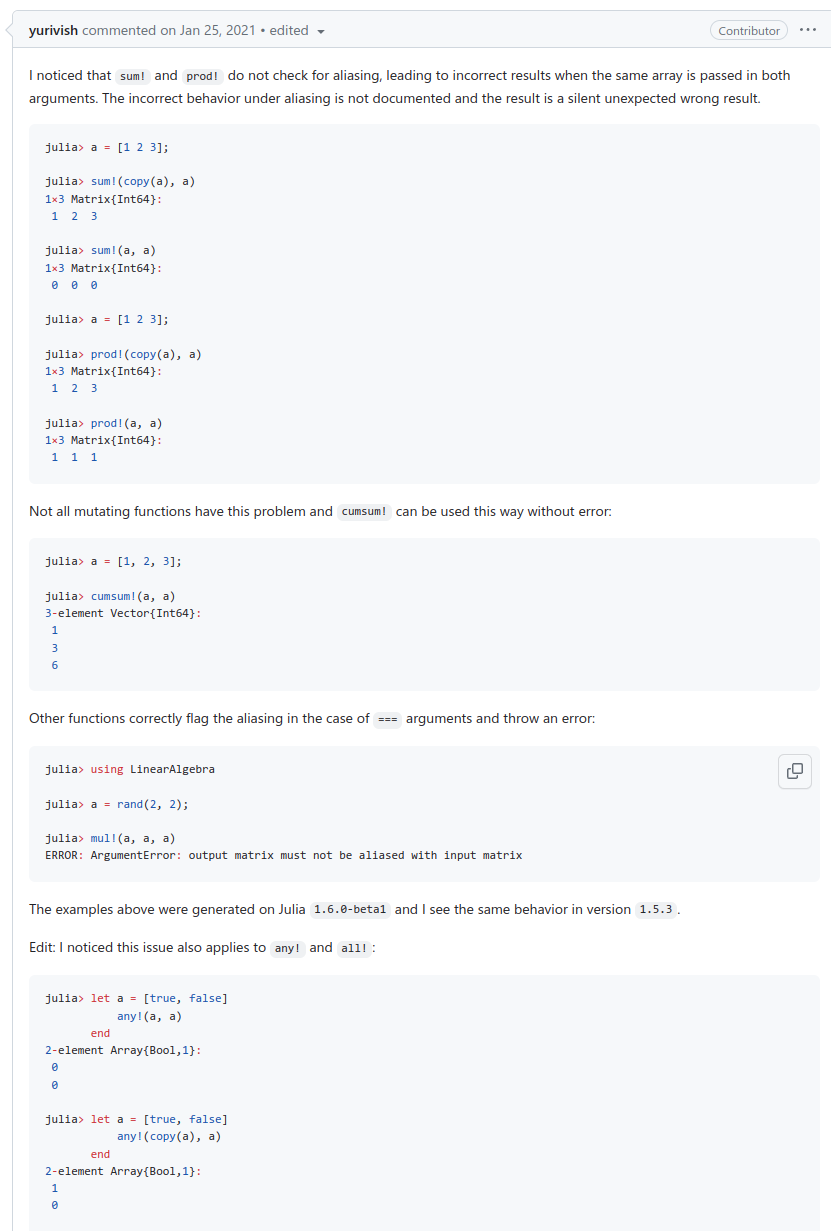

In [34]:
a = [1 2 3];
@show sum!(copy(a), a)
println("a=", a)

@show sum!(a, a)
println("a=", a)

a = [1 2 3];
@show sum!(a, a, init=false)

a = [1 2 3];
@show prod!(copy(a), a)
println("a=", a)

a = [1 2 3];
@show prod!(a, a)
println("a=", a)

a = [1 2 3];
@show prod!(a, a, init=false)
println("a=", a)

sum!(copy(a), a) = [1 2 3]
a=[1 2 3]
sum!(a, a) = [0 0 0]
a=[0 0 0]
sum!(a, a, init = false) = [2 4 6]
prod!(copy(a), a) = [1 2 3]
a=[1 2 3]
prod!(a, a) = [1 1 1]
a=[1 1 1]
prod!(a, a, init = false) = [1 4 9]
a=[1 4 9]


In [28]:
# cumsum!() returns correct result.
a = [1, 2, 3];
@show cumsum!(a, a)
println("a=",a)

cumsum!(a, a) = [1, 3, 6]
a=[1, 3, 6]


In [29]:
let a = [true, false]
   any!(a, a)
end

2-element Vector{Bool}:
 0
 0

In [30]:
let a = [true, false]
   any!(copy(a), a)
end

2-element Vector{Bool}:
 1
 0

In [31]:
let a = [true, false]
   all!(a, a)
end

2-element Vector{Bool}:
 1
 1

In [32]:
let a = [true, false]
   all!(copy(a), a)
end

2-element Vector{Bool}:
 1
 0

# 7 OrderedDict corrupted keys

SOLVED.

- https://github.com/JuliaCollections/OrderedCollections.jl/issues/71

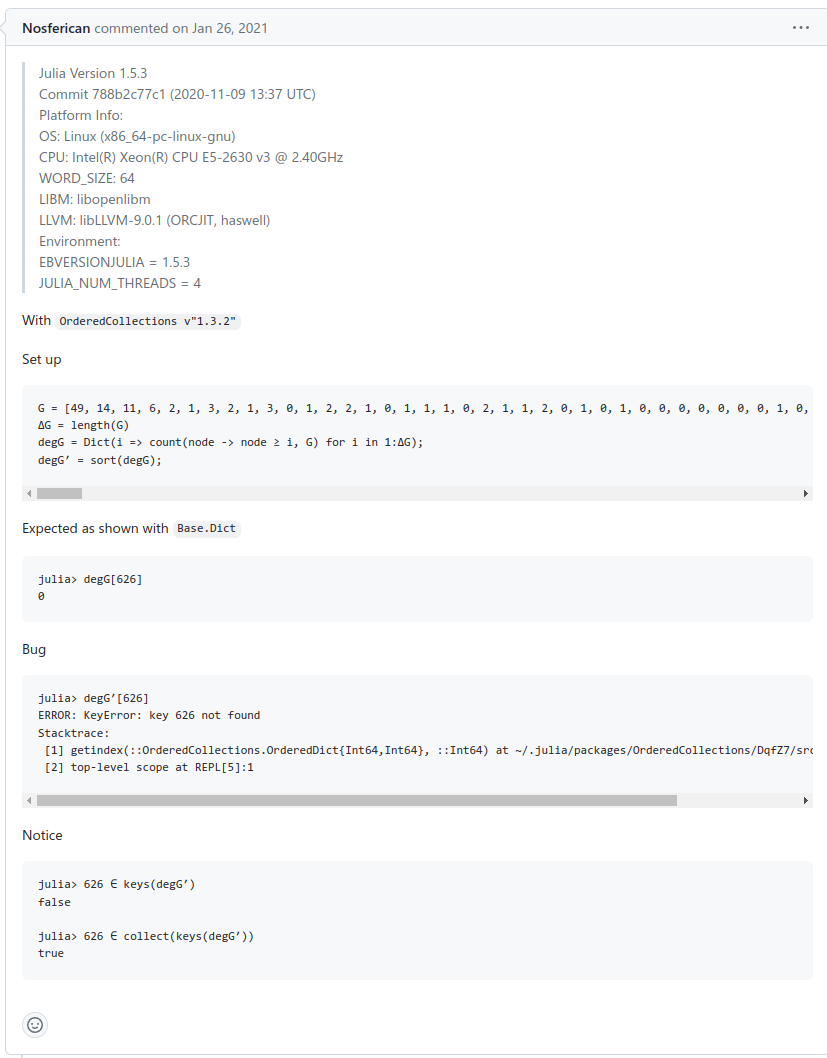

In [35]:
G = [49, 14, 11, 6, 2, 1, 3, 2, 1, 3, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
ΔG = length(G)
degG = Dict(i => count(node -> node ≥ i, G) for i in 1:ΔG);
degG′ = sort(degG);

In [36]:
degG[626]

0

In [37]:
degG′[626]

0

In [38]:
@show 626 ∈ keys(degG′)
@show 626 ∈ collect(keys(degG′))

626 ∈ keys(degG′) = true
626 ∈ collect(keys(degG′)) = true


true